In [1]:
import arcpy
from arcgis import GIS
from arcgis.mapping import WebMap

In [2]:
gis_url = 'https://onevm.maps.arcgis.com'
gis = GIS(gis_url,'PGE_OneVM')
print("\nLogged in to " + gis.properties.name + " as " + gis.properties.user.username)
me = gis.users.me

Enter password:  ········



Logged in to PG&E OneVM POC as PGE_OneVM


In [3]:
grid_or_features = 'grid'
if grid_or_features == 'grid':
    grid = r'C:\Users\jef10111\Documents\_Projects\PGE\PGE_Circuits_shapefile\Circuits_by_ID.shp'
    grid_field = 'CIRCUITNAM'
else:
    ## This was an attempt to get the data from a feature layer, but I couldn't get it to work. Don't remember why.
    feature_service = gis.content.get('a469833bec02495eb11f2cd6a127fa73')
    feature_layer = feature_service.layers[0]
    grid = feature_layer.query(where="1=1",out_fields="CIRCUITID,CIRCUITNAME")
    grid_field = 'CIRCUITNAME'

In [4]:
## This is just to list out the fields in the shapefile. You've already declared the field you're using above, but it's how I found it the first time.
fields = arcpy.ListFields(grid)

for field in fields:
    print("{0} is a type of {1} with a length of {2}"
          .format(field.name, field.type, field.length))

FID is a type of OID with a length of 4
Shape is a type of Geometry with a length of 0
CIRCUITID is a type of String with a length of 9
CIRCUITNAM is a type of String with a length of 50
Shape_Leng is a type of Double with a length of 19


In [5]:
## Get all of the grid extents from grid + grid_field and print them out with numbers so I know which grids to select for the inevitable re-run
## uses enumerate(,1) to start at 1
for x, row in enumerate(arcpy.da.SearchCursor(grid, ['SHAPE@', grid_field]),1):
    print(x,(row[0].extent.JSON),row[1])

1 {"xmin":-13733063.3588,"ymin":4742198.7590000033,"xmax":-13713256.7642,"ymax":4755828.2706000032,"spatialReference":{"wkid":102100,"latestWkid":3857}} UKIAH 1111
2 {"xmin":-13718962.346099999,"ymin":4737225.5291000009,"xmax":-13713456.178399999,"ymax":4742319.1784000006,"spatialReference":{"wkid":102100,"latestWkid":3857}} UKIAH 1113
3 {"xmin":-13727428.344999999,"ymin":4725064.4140999988,"xmax":-13700925.664799999,"ymax":4743066.0697999988,"spatialReference":{"wkid":102100,"latestWkid":3857}} UKIAH 1114
4 {"xmin":-13714855.0491,"ymin":4741690.5850000009,"xmax":-13708959.138700001,"ymax":4749085.2230000012,"spatialReference":{"wkid":102100,"latestWkid":3857}} UKIAH 1115
5 {"xmin":-13484471.259300001,"ymin":4702669.2286000028,"xmax":-13478655.326200001,"ymax":4705891.6656000027,"spatialReference":{"wkid":102100,"latestWkid":3857}} WISE 1101
6 {"xmin":-13495871.6357,"ymin":4704535.4397,"xmax":-13479682.3201,"ymax":4722032.6610000003,"spatialReference":{"wkid":102100,"latestWkid":3857}}

In [6]:
## Helper function that returns the offline_areas for a webmap rather than needing to keep the WebMap open
def get_offline_areas(item_id):
    wm_item = gis.content.get(item_id)
    if (wm_item.type == 'Web Map'):
        wm = WebMap(wm_item)
        oam = wm.offline_areas
        del(wm)
        del(wm_item)
        return oam
    else:
        raise TypeError(f"{item_id} is a {wm_item.type}, not 'Web Map' as expected.")

For VC maps, we need the following: Wise 1101, Wise 1102, Wheatland 1104, Brunswick 1104, Dobbins 1101, Browns Valley 1101, Brunswick 1107, and Wheatland 1105

For Veg, we need the following: Ukiah 1111, Ukiah 1113, Ukiah 1114, and Ukiah 1115

<Item title:"ESRI VC Mobile App" type:Web Map owner:PGE_OneVM>
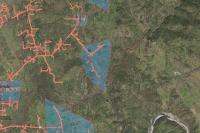

Checking existing map areas for WISE 1101
Creating offline map area for WISE 1101, starting at Thu May 13 21:04:55 2021
Submitted.
Executing...
Start Time: Friday, May 14, 2021 2:04:31 AM
CreateMapArea GP Job: j3cec597d6c9a4ea98965420b128ac86d finished successfully.
Submitted.
Executing...
Start Time: Friday, May 14, 2021 2:04:58 AM
Environmental_/FeatureServer - Get Service Definition
Environmental_/FeatureServer - Submit replica job
OneVM_Parcels/FeatureServer - Get Service Definition
OneVM_Parcels/FeatureServer - Submit replica job
SRA_LRA_FRA/FeatureServer - Get Service Definition
SRA_LRA_FRA/FeatureServer - Submit replica job
HFTD/FeatureServer - Get Service Definition
HFTD/FeatureServer - Submit replica job
EDGIS_Support_Structures/FeatureServer - Get Service Definition
EDGIS_Support_Structures/FeatureServer - Submit replica job
Work_Requests_v0/FeatureServer - Get Service Definition
Work_Requests_v0/FeatureServer - Submit replica job
Conductor_Inspections/FeatureServer - Get Ser

In [7]:
## main()

from arcgis import env
env.verbose = True
import json
import time

for i,j in {
    ## 90% of the work is done here. This is a dictionary defining the webmap ItemIDs that we want to create offline areas for, and a list of grid #s (from the list above)
    ## The loop below uses enumerate(,1) to start at 1, like the grid list above
    #'38161f31b5df4e9a8d973f50f6ac440b': [7],
    '3fc88a3ae17d45eca03b583c2c68f1b4': [5],
    #'e27286be7031452b975a3877c0c49d37': [6,7,9,10],
    #'d982b88723494e5c92155215e0e3e4fa': range(0,5),
    #'d9baae4234994efd882aa720175e3173': range(0,5)
}.items():
    wm_oam = get_offline_areas(i)
    display(wm_oam._item)
    wm_layers_to_ignore = None
    for x, row in enumerate(arcpy.da.SearchCursor(grid, ['SHAPE@',grid_field]),1):
        if x not in j: continue
        row_area = json.loads(row[0].extent.JSON)
        row_prop = {
            'title': row[1],
            'snippet': f'Offline map area for {row[1]}',
            'tags': ['python api', row[1],'field data collection']
        }
        r_title = row_prop['title']
        print(f"Checking existing map areas for {row[1]}")
        all_map_areas = wm_oam.list()
        for a_map in all_map_areas:
            #print(f"Checking {a_map.title} vs {row_prop['title']}")
            if a_map.title == r_title:
                delete_result = a_map.delete()
                if delete_result:
                    print(f"Successfully deleted existing map area for {r_title}")
                    print("Sleeping ",end="")
                    for s in range(0,5):
                        time.sleep(1)
                        print('.',end='')
                    print("\n")
                else:
                    print(f"Could not delete existing map area for {r_title}, skipping ...")
                    continue
        print(f"Creating offline map area for {row[1]}, starting at {time.ctime()}")
        start_time = time.time()
        try:
            result = wm_oam.create(
                area=row_area,
                item_properties=row_prop,
                min_scale=750000,
                max_scale=1250,
                layers_to_ignore=wm_layers_to_ignore
            )
            result_status = result.properties['status']
            if result_status == "failed":
                print(f"ERROR: {row[1]} status is {result_status}")
            else:
                print(f"{row[1]} status is {result_status}")
        except Exception as e:
            print(f"Error during creation for {r_title}: {str(e)}")
        finally:
            sec = int(time.time() - start_time)
            print(f"Offline area completed in {int(sec / 3600)} hours, {int((sec % 3600)/60)} mins, {int((sec % 3600)%60)} secs")
            print("Sleeping ",end="")
            for s in range(0,30):
                time.sleep(1)
                print('.',end='')
            print("\n")

In [109]:
## In case you want to see what's in the result object
dict(result)

{'id': '400821a499ea43538465b2f787cce5d8',
 'owner': 'PGE_OneVM',
 'created': 1618603341000,
 'isOrgItem': True,
 'modified': 1618603440000,
 'guid': None,
 'name': None,
 'title': 'DOBBINS 1101',
 'type': 'Map Area',
 'typeKeywords': ['Map', 'Map Area'],
 'description': None,
 'tags': ['python api', 'test', 'field data collection'],
 'snippet': 'Map with no advanced offline settings set (default is assumed to be features and attachments)',
 'thumbnail': None,
 'documentation': None,
 'extent': [[-121.280551, 39.310502], [-121.120491, 39.413493]],
 'categories': [],
 'spatialReference': 'GCS_WGS_1984',
 'accessInformation': None,
 'licenseInfo': None,
 'culture': 'english (united states)',
 'properties': {'status': 'complete',
  'extent': {'xmin': -13500889.1538,
   'ymin': 4766246.431400001,
   'xmax': -13483071.3952,
   'ymax': 4781075.104300001,
   'spatialReference': {'wkid': 102100, 'latestWkid': 3857}},
  'area': {'xmin': -13500889.1538,
   'ymin': 4766246.431400001,
   'xmax': -